<a href="https://colab.research.google.com/github/TonyHanzhiSU/DeepLearningFinalProject/blob/main/StockPricePredictionUsingTransformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D

import yfinance as yf

In [ ]:
def calculate_bollinger_bands(data, window=10, num_of_std=2):
    """Calculate Bollinger Bands"""
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, lower_band

def calculate_rsi(data, window=10):
    """Calculate Relative Strength Index"""
    delta = data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_roc(data, periods=10):
    """Calculate Rate of Change."""
    roc = ((data - data.shift(periods)) / data.shift(periods)) * 100
    return roc

def calculate_slow_stochastic_slope_diff(data, window=14):
    """Calculate Slow Stochastic and its slope difference."""
    # Calculate %K
    high_max = data['High'].rolling(window=window).max()
    low_min = data['Low'].rolling(window=window).min()
    k = ((data['Close'] - low_min) / (high_max - low_min)) * 100

    # Calculate %D
    d = k.rolling(window=3).mean()

    # Calculate slope difference
    k_slope = k.diff()
    d_slope = d.diff()

    slope_diff = k_slope - d_slope
    return slope_diff

In [ ]:
tickers = ['QQQ']

In [ ]:
ticker_data_frames = []
stats = {}
for ticker in tickers:
    print(f"\nProcessing {ticker}...")

    # Download historical data for the ticker
    data = yf.download(ticker, period="1mo", interval="5m")
    close = data['Close']
    #close = close.squeeze()

    # Print basic information about close to make sure data is downloaded correctly
    print(f"Length of close: {len(close)}")
    print(close.head())

    # Calculate the indicators and print their lengths and content
    upper, lower = calculate_bollinger_bands(close, window=14, num_of_std=2)
    width = upper - lower
    print(f"Length of width: {len(width)}")  # Debugging
    print(width.head())  # Optional

    rsi = calculate_rsi(close, window=14)
    print(f"Length of RSI: {len(rsi)}")  # Debugging
    print(rsi.head())  # Optional

    roc = calculate_roc(close, periods=14)
    print(f"Length of ROC: {len(roc)}")  # Debugging
    print(roc.head())  # Optional

    volume = data['Volume']
    print(f"Length of volume: {len(volume)}")  # Debugging
    print(volume.head())  # Optional

    diff = data['Close'].diff(1)
    print(f"Length of diff: {len(diff)}")  # Debugging
    print(diff.head())  # Optional

    percent_change_close = data['Close'].pct_change() * 100
    print(f"Length of percent_change_close: {len(percent_change_close)}")  # Debugging
    print(percent_change_close.head())  # Optional

    slow_stochastic_slope_diff = calculate_slow_stochastic_slope_diff(data, window=14)
    print(f"Length of slow_stochastic_slope_diff: {len(slow_stochastic_slope_diff)}")  # Debugging
    print(slow_stochastic_slope_diff.head())



Processing QQQ...


[*********************100%***********************]  1 of 1 completed

Length of close: 1602
Ticker                            QQQ
Datetime                             
2024-11-14 14:30:00+00:00  512.510010
2024-11-14 14:35:00+00:00  512.045410
2024-11-14 14:40:00+00:00  510.559998
2024-11-14 14:45:00+00:00  510.649994
2024-11-14 14:50:00+00:00  510.687592
Length of width: 1602
Ticker                     QQQ
Datetime                      
2024-11-14 14:30:00+00:00  NaN
2024-11-14 14:35:00+00:00  NaN
2024-11-14 14:40:00+00:00  NaN
2024-11-14 14:45:00+00:00  NaN
2024-11-14 14:50:00+00:00  NaN
Length of RSI: 1602
Ticker                          QQQ
Datetime                           
2024-11-14 14:30:00+00:00       NaN
2024-11-14 14:35:00+00:00  0.000000
2024-11-14 14:40:00+00:00  0.000000
2024-11-14 14:45:00+00:00  4.411567
2024-11-14 14:50:00+00:00  6.141395
Length of ROC: 1602
Ticker                     QQQ
Datetime                      
2024-11-14 14:30:00+00:00  NaN
2024-11-14 14:35:00+00:00  NaN
2024-11-14 14:40:00+00:00  NaN
2024-11-14 14:45:00+00:00 

In [ ]:
close = close.squeeze()
width = width.squeeze()
rsi = rsi.squeeze()
roc = roc.squeeze()
volume = volume.squeeze()
diff = diff.squeeze()
percent_change_close = percent_change_close.squeeze()
slow_stochastic_slope_diff = slow_stochastic_slope_diff.squeeze()

In [ ]:


print(f"Types: {type(close)}, {type(width)}, {type(rsi)}, {type(roc)}, {type(volume)}, {type(diff)}, {type(percent_change_close)},{type(slow_stochastic_slope_diff)}")

lengths = [len(close), len(width), len(rsi), len(roc), len(volume), len(diff), len(percent_change_close),len(slow_stochastic_slope_diff)]
if len(set(lengths)) != 1:
    print(f"Length mismatch for {ticker}: {lengths}. Skipping.")


Types: <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>,<class 'pandas.core.series.Series'>


In [ ]:
    # Create a DataFrame for the current ticker and append it to the list
    ticker_df = pd.DataFrame({
        ticker+'_close': close,
        ticker+'_width': width,
        ticker+'_rsi': rsi,
        ticker+'_roc': roc,
        ticker+'_volume': volume,
        ticker+'_diff': diff,
        ticker+'_percent_change_close': percent_change_close,
        ticker+'_slow_stochastic_slope_diff': slow_stochastic_slope_diff
    })

    MEAN = ticker_df.mean()
    STD = ticker_df.std()

    # Keep track of mean and std
    for column in MEAN.index:
      stats[f"{column}_mean"] = MEAN[column]
      stats[f"{column}_std"] = STD[column]

    # Normalize the training features
    ticker_df = (ticker_df - MEAN) / STD

    ticker_data_frames.append(ticker_df)

In [ ]:
# Convert stats from dict to df
stats = pd.DataFrame([stats], index=[0])
stats.head()

,QQQ_close_mean,QQQ_close_std,QQQ_width_mean,QQQ_width_std,QQQ_rsi_mean,QQQ_rsi_std,QQQ_roc_mean,QQQ_roc_std,QQQ_volume_mean,QQQ_volume_std,QQQ_diff_mean,QQQ_diff_std,QQQ_percent_change_close_mean,QQQ_percent_change_close_std,QQQ_slow_stochastic_slope_diff_mean,QQQ_slow_stochastic_slope_diff_std
0,510.135281,7.694425,2.22155,1.794766,53.22181,16.824593,0.027267,0.335323,314107.885144,303084.453925,0.010806,0.464533,0.002129,0.091567,0.001563,14.910736


In [ ]:
MEAN['QQQ_close']

510.1352811853835

In [ ]:
STD['QQQ_close']

7.694425412154358

In [ ]:
# Concatenate all ticker DataFrames
df = pd.concat(ticker_data_frames, axis=1)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.head()

,QQQ_close,QQQ_width,QQQ_rsi,QQQ_roc,QQQ_volume,QQQ_diff,QQQ_percent_change_close,QQQ_slow_stochastic_slope_diff
Datetime,,,,,,,,
2024-11-07 15:50:00+00:00,0.203371,0.039263,1.155134,0.936286,0.136101,-0.388986,-0.385718,-0.971420
2024-11-07 15:55:00+00:00,0.250144,-0.070313,1.712276,1.358281,-0.114832,0.751481,0.744854,0.372156
2024-11-07 16:00:00+00:00,0.215055,-0.208989,1.238161,0.959509,0.759030,-0.604466,-0.599066,-0.657926
2024-11-07 16:05:00+00:00,0.186463,-0.203139,0.465632,0.309781,-0.254836,-0.496858,-0.492703,-0.444783
2024-11-07 16:10:00+00:00,0.215912,-0.181209,0.662137,0.459696,-0.111708,0.464525,0.460480,1.246799


In [ ]:
# Shift the df data to create labels
labels = df.shift(-1)

# Drop the last row in both percent_change_data and labels as it won't have a corresponding label
df = df.iloc[:-1]
labels = labels.iloc[:-1]

In [ ]:
# Sequence len = 24 means that we have 2 hours of 5 min data
SEQUENCE_LEN = 24

# Function to create X-day sequences for each ticker

def create_sequences(data, labels, mean, std, sequence_length=SEQUENCE_LEN):
    sequences = []
    lab = []
    data_size = len(data)

    # +13 to predict next hour, +2 to predict next interval
    for i in range(data_size - (sequence_length + 2)):
      if i == 0:
        continue

      sequences.append(data[i:i + sequence_length])
      lab.append([labels[i-1], labels[i + 1], mean[0], std[0]])

    for i in range(0, len(lab)):
      last_price_data = sequences[i][-1][0]
      last_price_label = lab[i][0]

      if not last_price_data == last_price_label:
        print(f"ERROR : {last_price_data=} and {last_price_label=} are not equal")

    return np.array(sequences), np.array(lab)



In [ ]:
sequences_dict = {}
sequence_labels = {}
for ticker in tickers:

    # Extract close and volume data for the ticker
    close = df[ticker+'_close'].values
    width = df[ticker+'_width'].values
    rsi = df[ticker+'_rsi'].values
    roc = df[ticker+'_roc'].values
    volume = df[ticker+'_volume'].values
    diff = df[ticker+'_diff'].values
    pct_change = df[ticker+'_percent_change_close'].values
    slow_stochastic_slope_diff = df[ticker+'_slow_stochastic_slope_diff'].values

    # Combine close and volume data
    ticker_data = np.column_stack((close,
                                   width,
                                   rsi,
                                   roc,
                                   volume,
                                   diff,
                                   pct_change,
                                   slow_stochastic_slope_diff))

    # Generate sequences
    attribute = ticker+"_close"
    ticker_sequences, lab = create_sequences(ticker_data,
                                             labels[attribute].values[SEQUENCE_LEN-1:],
                                             stats[attribute+"_mean"].values,
                                             stats[attribute+"_std"].values)

    sequences_dict[ticker] = ticker_sequences
    sequence_labels[ticker] = lab

In [ ]:
sequences_dict['QQQ'].shape

(1558, 24, 8)

In [ ]:
sequence_labels['QQQ'].shape

(1558, 4)

In [ ]:
# Combine data and labels from all tickers
all_sequences = []
all_labels = []

for ticker in tickers:
    all_sequences.extend(sequences_dict[ticker])
    all_labels.extend(sequence_labels[ticker])

# Convert to numpy arrays
all_sequences = np.array(all_sequences)
all_labels = np.array(all_labels)

In [ ]:
all_labels[0][1]*STD['QQQ_close'] + MEAN['QQQ_close']

512.7100219726562

In [ ]:
all_sequences.shape

(1558, 24, 8)

In [ ]:
np.random.seed(42)
shuffled_indices = np.random.permutation(len(all_sequences))
all_sequences = all_sequences[shuffled_indices]
all_labels = all_labels[shuffled_indices]

train_size = int(len(all_sequences) * 0.9)

# Split sequences
train_sequences = all_sequences[:train_size]
train_labels    = all_labels[:train_size]

other_sequences = all_sequences[train_size:]
other_labels    = all_labels[train_size:]

shuffled_indices = np.random.permutation(len(other_sequences))
other_sequences = other_sequences[shuffled_indices]
other_labels = other_labels[shuffled_indices]

val_size = int(len(other_sequences) * 0.5)

validation_sequences = other_sequences[:val_size]
validation_labels = other_labels[:val_size]

test_sequences = other_sequences[val_size:]
test_labels = other_labels[val_size:]

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Add()([x, inputs])

    # Feed Forward Part
    y = LayerNormalization(epsilon=1e-6)(x)
    y = Dense(ff_dim, activation="relu")(y)
    y = Dropout(dropout)(y)
    y = Dense(inputs.shape[-1])(y)
    return Add()([y, x])

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs

    # Create multiple layers of the Transformer block
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Final part of the model
    x = GlobalAveragePooling1D()(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    outputs = Dense(1, activation="linear")(x)

    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model parameters
input_shape = train_sequences.shape[1:]
head_size = 256
num_heads = 16
ff_dim = 1024
num_layers = 12
dropout = 0.20

# Build the model
model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 24, 8)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 24, 8)          │             16 │ input_layer[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 24, 8)          │        143,368 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 24, 8)          │              0 │ multi_head_attention[… │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 24, 8)          │             16 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 24, 1024)       │          9,216 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 24, 1024)       │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 24, 8)          │          8,200 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 24, 8)          │              0 │ dense_1[0][0],         │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 24, 8)          │             16 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 24, 8)          │        143,368 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 24, 8)          │              0 │ multi_head_attention_… │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 24, 8)          │             16 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 24, 1024)       │          9,216 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 24, 1024)       │              0 │ dense_2[0][0]          │
├──────────────────────

 Total params: 1,929,817 (7.36 MB)

 Trainable params: 1,929,817 (7.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def custom_mae_loss(y_true, y_pred):
    y_true_next = tf.cast(y_true[:, 1], tf.float64)
    y_pred_next = tf.cast(y_pred[:, 0], tf.float64)
    abs_error = tf.abs(y_true_next - y_pred_next)

    return tf.reduce_mean(abs_error)

def dir_acc(y_true, y_pred):
    mean, std = tf.cast(y_true[:, 2], tf.float64), tf.cast(y_true[:, 3], tf.float64)

    y_true_prev = (tf.cast(y_true[:, 0], tf.float64) * std) + mean
    y_true_next = (tf.cast(y_true[:, 1], tf.float64) * std) + mean
    y_pred_next = (tf.cast(y_pred[:, 0], tf.float64) * std) + mean

    true_change = y_true_next - y_true_prev
    pred_change = y_pred_next - y_true_prev

    correct_direction = tf.equal(tf.sign(true_change), tf.sign(pred_change))

    return tf.reduce_mean(tf.cast(correct_direction, tf.float64))

In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=custom_mae_loss, metrics=[dir_acc])

In [ ]:
# Define a callback to save the best model
checkpoint_callback_train = ModelCheckpoint(
    "transformer_train_model.keras",  # Filepath to save the best model
    monitor="dir_acc",  #"loss",  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode="max",  # Minimize the monitored metric
    verbose=1,  # Display progress
)

# Define a callback to save the best model
checkpoint_callback_val = ModelCheckpoint(
    "transformer_val_model.keras",  # Filepath to save the best model
    monitor="val_dir_acc", #"val_loss",  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode="max",  # Minimize the monitored metric
    verbose=1,  # Display progress
)

def get_lr_callback(batch_size=16, mode='cos', epochs=500, plot=False):
    lr_start, lr_max, lr_min = 0.0001, 0.005, 0.00001  # Adjust learning rate boundaries
    lr_ramp_ep = int(0.30 * epochs)  # 30% of epochs for warm-up
    lr_sus_ep = max(0, int(0.10 * epochs) - lr_ramp_ep)  # Optional sustain phase, adjust as needed

    def lrfn(epoch):
        if epoch < lr_ramp_ep:  # Warm-up phase
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:  # Sustain phase at max learning rate
            lr = lr_max
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        else:
            lr = lr_min  # Default to minimum learning rate if mode is not recognized

        return lr

    if plot:  # Plot learning rate curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
model.fit(train_sequences, train_labels,
          validation_data=(validation_sequences, validation_labels),
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=True,
          callbacks=[checkpoint_callback_train, checkpoint_callback_val, get_lr_callback(batch_size=BATCH_SIZE, epochs=EPOCHS)])


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dir_acc: 0.5128 - loss: 0.8171  
Epoch 1: dir_acc improved from -inf to 0.51136, saving model to transformer_train_model.keras

Epoch 1: val_dir_acc improved from -inf to 0.65513, saving model to transformer_val_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - dir_acc: 0.5127 - loss: 0.8035 - val_dir_acc: 0.6551 - val_loss: 0.2260 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00026333333333333336.
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - dir_acc: 0.4878 - loss: 0.2717
Epoch 2: dir_acc did not improve from 0.51136

Epoch 2: val_dir_acc did not improve from 0.65513
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - dir_acc: 0.4878 - loss: 0.2705 - val_dir_acc: 0.5949 - val_loss: 0.1937 - learning_rate: 2.6333e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00042666666666666667.
Epoch 3/100
22/22 ━━━━━━━━━━━━━

In [ ]:
# Load Weights
model.load_weights("transformer_val_model.keras")

# Make predictions
accuracy = model.evaluate(test_sequences, test_labels)[1]
print(accuracy)

# Calculate additional metrics as needed
from sklearn.metrics import r2_score

predictions = model.predict(test_sequences)
r2 = r2_score(test_labels[:, 1], predictions[:, 0])
print(f"R-squared: {r2}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - dir_acc: 0.6957 - loss: 0.0613
0.6726190447807312
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
R-squared: 0.9934970337349043


## Using PatchTST to predict the price of QQQ

In [ ]:
import yfinance as yf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm


ticker = "QQQ"
# 1 month of 5-minute intervals
data = yf.download(ticker, period="1mo", interval="5m")

if len(data) == 0:
    raise ValueError("No data downloaded. Adjust your ticker or date range.")

close = data['Close']

# Compute Indicators
upper, lower = calculate_bollinger_bands(close, window=14, num_of_std=2)
width = upper - lower
rsi = calculate_rsi(close, window=14)
roc = calculate_roc(close, periods=14)
volume = data['Volume']
slow_stochastic_slope_diff = calculate_slow_stochastic_slope_diff(data, window=14)

close = close.squeeze()
width = width.squeeze()
rsi = rsi.squeeze()
roc = roc.squeeze()
volume = volume.squeeze()
slow_stochastic_slope_diff = slow_stochastic_slope_diff.squeeze()


# Combine into a single DataFrame
features_df = pd.DataFrame({
    'Close': close,
    'BB_width': width,
    'RSI': rsi,
    'ROC': roc,
    'Volume': volume,
    'SlowStochSlopeDiff': slow_stochastic_slope_diff
})

# Drop NaNs
features_df = features_df.dropna()



MEAN = features_df.mean()
STD = features_df.std()

# Normalize the training features
features_df = (features_df - MEAN) / STD


[*********************100%***********************]  1 of 1 completed


#### Dataset Preparation

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, input_length=30, forecast_horizon=1):
        self.data = df.values
        self.input_length = input_length
        self.forecast_horizon = forecast_horizon

    def __len__(self):
        return len(self.data) - self.input_length - self.forecast_horizon + 1


    def __getitem__(self, idx):
        X = self.data[idx:idx+self.input_length]          # shape: (input_length, channels)
        y = self.data[idx+self.input_length:idx+self.input_length+self.forecast_horizon]
        # Now y includes all channels, shape: (forecast_horizon, channels)
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Split data
num_samples = len(features_df)
train_size = int(num_samples * 0.7)
val_size = int(num_samples * 0.15)
test_size = num_samples - train_size - val_size

train_df = features_df.iloc[:train_size]
val_df = features_df.iloc[train_size:train_size+val_size]
test_df = features_df.iloc[train_size+val_size:]

input_length = 24
forecast_horizon = 1
channels = features_df.shape[1]  # 6 features: Close, BB_width, RSI, ROC, Volume, SlowStochSlopeDiff

train_dataset = TimeSeriesDataset(train_df, input_length=input_length, forecast_horizon=forecast_horizon)
val_dataset = TimeSeriesDataset(val_df, input_length=input_length, forecast_horizon=forecast_horizon)
test_dataset = TimeSeriesDataset(test_df, input_length=input_length, forecast_horizon=forecast_horizon)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [ ]:
def direction_accuracy(preds, truths):

    pred_directions = torch.sign(preds[:, :, 0] - truths[:, :, 0])
    true_directions = torch.sign(truths[:, :, 0] - truths[:, :, 0].roll(shifts=1, dims=1))

    print(f"Pred Directions: {pred_directions}")
    print(f"True Directions: {true_directions}")


    correct_directions = (pred_directions == true_directions).float()
    return correct_directions.mean().item()



In [ ]:
from transformers import PatchTSTConfig, PatchTSTForPrediction

config = PatchTSTConfig(
    num_input_channels=channels,
    context_length=input_length,
    prediction_length=forecast_horizon,
    patch_len=5,
    d_model=64,
    n_heads=4,
    num_encoder_layers=2,
    dropout=0.1
)

model = PatchTSTForPrediction(config)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
del model
torch.cuda.empty_cache()

In [ ]:
features_df.shape

(1586, 6)

In [ ]:
print(model.config)

PatchTSTConfig {
  "_attn_implementation_autoset": true,
  "activation_function": "gelu",
  "attention_dropout": 0.0,
  "bias": true,
  "channel_attention": false,
  "channel_consistent_masking": false,
  "context_length": 24,
  "d_model": 64,
  "distribution_output": "student_t",
  "do_mask_input": null,
  "dropout": 0.1,
  "ff_dropout": 0.0,
  "ffn_dim": 512,
  "head_dropout": 0.0,
  "init_std": 0.02,
  "loss": "mse",
  "mask_type": "random",
  "mask_value": 0,
  "model_type": "patchtst",
  "n_heads": 4,
  "norm_eps": 1e-05,
  "norm_type": "batchnorm",
  "num_attention_heads": 4,
  "num_encoder_layers": 2,
  "num_forecast_mask_patches": [
    2
  ],
  "num_hidden_layers": 3,
  "num_input_channels": 6,
  "num_parallel_samples": 100,
  "num_targets": 1,
  "output_range": null,
  "patch_len": 5,
  "patch_length": 1,
  "patch_stride": 1,
  "path_dropout": 0.0,
  "pooling_type": "mean",
  "positional_dropout": 0.0,
  "positional_encoding_type": "sincos",
  "pre_norm": true,
  "prediction_

In [ ]:
for X, y in train_loader:
    print(X.shape, y.shape)
    # Should be X: (batch, 30, 6), y: (batch, 1, 6)
    break

torch.Size([32, 24, 6]) torch.Size([32, 1, 6])


In [ ]:
print(train_dataset[0][1][:5])


tensor([[-0.2900, -0.0587, -0.7642, -0.7173,  0.4919,  3.0348]])


### Training

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
'''
def train_epoch(model, dataloader, optimizer, criterion, device='cpu'):
    model.train()
    total_loss = 0
    for X, y in tqdm(dataloader, desc="Training", leave=False):
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        preds = model(past_values=X, future_values=y)
        preds = preds.prediction_outputs
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
    return total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion, device='cpu'):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Training", leave=False):
            X = X.to(device)
            y = y.to(device)
            preds = model(past_values=X)
            preds = preds.prediction_outputs
            loss = criterion(preds, y)
            total_loss += loss.item() * X.size(0)
    return total_loss / len(dataloader.dataset)
    '''

def train_epoch(model, dataloader, optimizer, criterion, device='cpu'):
    model.train()
    total_loss = 0
    total_dir_acc = 0

    for X, y in tqdm(dataloader, desc="Training", leave=False):
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        preds = model(past_values=X, future_values=y)
        preds = preds.prediction_outputs
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)


        total_dir_acc += direction_accuracy(preds, y) * X.size(0)

    avg_loss = total_loss / len(dataloader.dataset)
    avg_dir_acc = total_dir_acc / len(dataloader.dataset)
    return avg_loss, avg_dir_acc


def evaluate(model, dataloader, criterion, device='cpu'):
    model.eval()
    total_loss = 0
    total_dir_acc = 0

    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Evaluating", leave=False):
            X = X.to(device)
            y = y.to(device)
            preds = model(past_values=X)
            preds = preds.prediction_outputs
            loss = criterion(preds, y)
            total_loss += loss.item() * X.size(0)

            total_dir_acc += direction_accuracy(preds, y) * X.size(0)

    avg_loss = total_loss / len(dataloader.dataset)
    avg_dir_acc = total_dir_acc / len(dataloader.dataset)
    return avg_loss, avg_dir_acc

'''
epochs = 150
for epoch in range(1, epochs+1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch}/{epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

test_loss = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
'''

epochs = 10
for epoch in range(1, epochs + 1):
    train_loss, train_dir_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_dir_acc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch}/{epochs}: Train Loss = {train_loss:.4f}, Train Dir Acc = {train_dir_acc:.4f}, "
          f"Val Loss = {val_loss:.4f}, Val Dir Acc = {val_dir_acc:.4f}")

test_loss, test_dir_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Dir Acc: {test_dir_acc:.4f}")



Training:  21%|██        | 7/34 [00:00<00:01, 21.04it/s]

Pred Directions: tensor([[-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  53%|█████▎    | 18/34 [00:00<00:00, 37.42it/s]

Pred Directions: tensor([[ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  88%|████████▊ | 30/34 [00:00<00:00, 45.93it/s]

Pred Directions: tensor([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Pred Directions: tensor([[ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')


Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0')
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pr

Training:  18%|█▊        | 6/34 [00:00<00:00, 55.45it/s]

Pred Directions: tensor([[ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  53%|█████▎    | 18/34 [00:00<00:00, 55.93it/s]

True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pred Directions: tensor([[ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.]], device='cuda:0', gr

Training:  71%|███████   | 24/34 [00:00<00:00, 56.01it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.]], device='cuda:0', gr

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0')
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pr

Training:   0%|          | 0/34 [00:00<?, ?it/s]

Pred Directions: tensor([[-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  15%|█▍        | 5/34 [00:00<00:00, 44.41it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  32%|███▏      | 11/34 [00:00<00:00, 50.51it/s]

True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pred Directions: tensor([[-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.]], device='cuda:0', gr

Training:  50%|█████     | 17/34 [00:00<00:00, 44.56it/s]

Pred Directions: tensor([[ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  65%|██████▍   | 22/34 [00:00<00:00, 41.97it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  79%|███████▉  | 27/34 [00:00<00:00, 41.35it/s]

True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pred Directions: tensor([[-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.]], device='cuda:0', gr

Training:  94%|█████████▍| 32/34 [00:00<00:00, 41.23it/s]

Pred Directions: tensor([[ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Pred Directions: tensor([[ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Pred Directions: tensor([[ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.]], device='cuda:0')
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pr

Pred Directions: tensor([[ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.]], device='cuda:0')
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pr

Training:   0%|          | 0/34 [00:00<?, ?it/s]

Pred Directions: tensor([[ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  12%|█▏        | 4/34 [00:00<00:00, 37.93it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  24%|██▎       | 8/34 [00:00<00:00, 35.22it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  35%|███▌      | 12/34 [00:00<00:00, 34.38it/s]

Pred Directions: tensor([[-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  50%|█████     | 17/34 [00:00<00:00, 36.57it/s]

Pred Directions: tensor([[-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  62%|██████▏   | 21/34 [00:00<00:00, 37.57it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  76%|███████▋  | 26/34 [00:00<00:00, 39.55it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  91%|█████████ | 31/34 [00:00<00:00, 40.90it/s]

Pred Directions: tensor([[ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Pred Directions: tensor([[-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0')
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pr

Pred Directions: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Epoch 4/10: Train Loss = 0.4653, Train Dir Acc = 0.0000, Val Loss = 0.3722, Val Dir Acc = 0.0000


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  12%|█▏        | 4/34 [00:00<00:00, 32.71it/s]

Pred Directions: tensor([[ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  24%|██▎       | 8/34 [00:00<00:00, 31.45it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  35%|███▌      | 12/34 [00:00<00:00, 33.32it/s]

True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pred Directions: tensor([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.]], device='cuda:0', gr

Training:  47%|████▋     | 16/34 [00:00<00:00, 34.12it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  59%|█████▉    | 20/34 [00:00<00:00, 34.11it/s]

True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pred Directions: tensor([[ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.]], device='cuda:0', gr

Training:  71%|███████   | 24/34 [00:00<00:00, 34.66it/s]

True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pred Directions: tensor([[-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]], device='cuda:0', gr

Training:  82%|████████▏ | 28/34 [00:00<00:00, 34.17it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Pred Directions: tensor([[-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0')
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pr

Evaluating: 100%|██████████| 7/7 [00:00<00:00, 63.83it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.]], device='cuda:0')
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pr

Epoch 5/10: Train Loss = 0.4576, Train Dir Acc = 0.0000, Val Loss = 0.3476, Val Dir Acc = 0.0000


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Pred Directions: tensor([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  12%|█▏        | 4/34 [00:00<00:00, 34.03it/s]

Pred Directions: tensor([[ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  24%|██▎       | 8/34 [00:00<00:00, 37.16it/s]

Pred Directions: tensor([[ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  35%|███▌      | 12/34 [00:00<00:00, 38.22it/s]


True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.]], device='cuda:0', g

Training:  47%|████▋     | 16/34 [00:00<00:00, 38.37it/s]

Pred Directions: tensor([[ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  59%|█████▉    | 20/34 [00:00<00:00, 37.72it/s]

Pred Directions: tensor([[ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  74%|███████▎  | 25/34 [00:00<00:00, 38.63it/s]

Pred Directions: tensor([[ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  88%|████████▊ | 30/34 [00:00<00:00, 39.13it/s]

Pred Directions: tensor([[-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.]], device='cuda:0')
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pr

Pred Directions: tensor([[ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.]], device='cuda:0')
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Epoch 6/10: Train Loss = 0.4393, Train Dir Acc = 0.0000, Val Loss = 0.3705, Val Dir Acc = 0.0000


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:   9%|▉         | 3/34 [00:00<00:01, 27.79it/s]

Pred Directions: tensor([[ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  21%|██        | 7/34 [00:00<00:00, 32.65it/s]

Pred Directions: tensor([[-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  32%|███▏      | 11/34 [00:00<00:00, 34.09it/s]

Pred Directions: tensor([[-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  50%|█████     | 17/34 [00:00<00:00, 40.16it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  68%|██████▊   | 23/34 [00:00<00:00, 44.76it/s]

Pred Directions: tensor([[-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  82%|████████▏ | 28/34 [00:00<00:00, 45.89it/s]

Pred Directions: tensor([[-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0')
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pr

Pred Directions: tensor([[ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0')
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Epoch 7/10: Train Loss = 0.4224, Train Dir Acc = 0.0000, Val Loss = 0.3727, Val Dir Acc = 0.0000


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Pred Directions: tensor([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  15%|█▍        | 5/34 [00:00<00:00, 44.61it/s]

True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pred Directions: tensor([[-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', gr

Training:  29%|██▉       | 10/34 [00:00<00:00, 40.05it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  47%|████▋     | 16/34 [00:00<00:00, 44.89it/s]

Pred Directions: tensor([[-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  62%|██████▏   | 21/34 [00:00<00:00, 46.62it/s]

Pred Directions: tensor([[-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  79%|███████▉  | 27/34 [00:00<00:00, 48.30it/s]

Pred Directions: tensor([[ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  94%|█████████▍| 32/34 [00:00<00:00, 48.64it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Pred Directions: tensor([[ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.]], device='cuda:0')
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pr

True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pred Directions: tensor([[ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.]], device='cuda:0')
Tr

Training:   0%|          | 0/34 [00:00<?, ?it/s]

Pred Directions: tensor([[ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  18%|█▊        | 6/34 [00:00<00:00, 53.51it/s]

True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pred Directions: tensor([[ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]], device='cuda:0', gr

Training:  35%|███▌      | 12/34 [00:00<00:00, 51.37it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  53%|█████▎    | 18/34 [00:00<00:00, 44.57it/s]

Pred Directions: tensor([[ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  68%|██████▊   | 23/34 [00:00<00:00, 44.86it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  82%|████████▏ | 28/34 [00:00<00:00, 46.24it/s]

Pred Directions: tensor([[ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', gr

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Pred Directions: tensor([[ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.]], device='cuda:0')
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pr

Pred Directions: tensor([[ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.]], device='cuda:0')
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pr

Training:   0%|          | 0/34 [00:00<?, ?it/s]

Pred Directions: tensor([[-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  15%|█▍        | 5/34 [00:00<00:00, 48.41it/s]

Pred Directions: tensor([[-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  29%|██▉       | 10/34 [00:00<00:00, 47.68it/s]

True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pred Directions: tensor([[-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', gr

Training:  44%|████▍     | 15/34 [00:00<00:00, 47.94it/s]

Pred Directions: tensor([[ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  59%|█████▉    | 20/34 [00:00<00:00, 47.29it/s]

Pred Directions: tensor([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  74%|███████▎  | 25/34 [00:00<00:00, 42.46it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Training:  88%|████████▊ | 30/34 [00:00<00:00, 40.57it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Pred Directions: tensor([[-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.]], device='cuda:0', grad_fn=<SignBackward0>)
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Pred Directions: tensor([[ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.]], device='cuda:0')
True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pr

True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Epoch 10/10: Train Loss = 0.4139, Train Dir Acc = 0.0000, Val Loss = 0.3685, Val Dir Acc = 0.0000


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Pred Directions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.]], device='cuda:0')


True Directions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Pred Directions: tensor([[-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.]], device='cuda:0')
Tr

### Evaluation

In [ ]:
from sklearn.metrics import r2_score
import torch
import numpy as np

model.eval()
all_preds = []
all_truths = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)  # y: (batch, 1, channels)

        # For inference, if you don't provide future_values, model returns predictions.
        # If you do provide them, you get supervised outputs with loss.
        # Here, let's just do inference without providing future_values.
        outputs = model(past_values=X)
        preds = outputs.prediction_outputs  # (batch, prediction_length=1, channels)

        # Select the channel you want to evaluate. For example, channel=0:
        preds_channel = preds[..., 0].cpu().numpy()  # shape: (batch, 1) => (batch,)
        truths_channel = y[..., 0].cpu().numpy()     # shape: (batch, 1) => (batch,)

        all_preds.append(preds_channel)
        all_truths.append(truths_channel)

# Concatenate all batches
all_preds = np.concatenate(all_preds, axis=0)   # shape: (total_samples,)
all_truths = np.concatenate(all_truths, axis=0) # shape: (total_samples,)

# Compute R² score for the selected channel
r2 = r2_score(all_truths, all_preds)
print(f"R² score on test set (channel 0): {r2:.4f}")


# Define accuracy as percentage of predictions within 5% of true values
accuracy_threshold = 0.03
relative_errors = np.abs((all_preds - all_truths) / all_truths)
accuracy = np.mean(relative_errors < accuracy_threshold)
print(f"Accuracy (within 3% error): {accuracy:.4f}")

R² score on test set (channel 0): 0.7920
Accuracy (within 3% error): 0.7895


**New Evaluation**

In [ ]:
from sklearn.metrics import r2_score
import torch
import numpy as np

model.eval()
all_preds = []
all_truths = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        outputs = model(past_values=X)
        preds = outputs.prediction_outputs
        all_preds.append(preds)
        all_truths.append(y)

all_preds = torch.cat(all_preds, dim=0)
all_truths = torch.cat(all_truths, dim=0)


test_dir_acc = direction_accuracy(all_preds, all_truths)
print(f"Test Dir Acc: {test_dir_acc:.4f}")


all_preds = (all_preds * STD.values[0]) + MEAN.values[0]
all_truths = (all_truths * STD.values[0]) + MEAN.values[0]


r2 = r2_score(all_truths, all_preds)
print(f"R² score on test set (channel 0, denormalized): {r2:.4f}")



Test Dir Acc: 0.0000


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

# New PatchTST predict method

In [ ]:
import math
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D

import yfinance as yf

In [ ]:
def calculate_bollinger_bands(data, window=10, num_of_std=2):
    """Calculate Bollinger Bands"""
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, lower_band

def calculate_rsi(data, window=10):
    """Calculate Relative Strength Index"""
    delta = data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_roc(data, periods=10):
    """Calculate Rate of Change."""
    roc = ((data - data.shift(periods)) / data.shift(periods)) * 100
    return roc

def calculate_slow_stochastic_slope_diff(data, window=14):
    """Calculate Slow Stochastic and its slope difference."""
    # Calculate %K
    high_max = data['High'].rolling(window=window).max()
    low_min = data['Low'].rolling(window=window).min()
    k = ((data['Close'] - low_min) / (high_max - low_min)) * 100

    # Calculate %D
    d = k.rolling(window=3).mean()

    # Calculate slope difference
    k_slope = k.diff()
    d_slope = d.diff()

    slope_diff = k_slope - d_slope
    return slope_diff

In [ ]:
tickers = ['QQQ']

**Try other data API**

In [ ]:
'''!pip install -U polygon-api-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 14.1
    Uninstalling websockets-14.1:
      Successfully uninstalled websockets-14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 0.1.0 requires websockets<15.0dev,>=13.0, but you have websockets 12.0 which is incompatible.


In [ ]:
''' currently not working '''
'''
from polygon import RESTClient
import pandas as pd

# Polygon.io API Key
api_key = "CZvdNVqf88p9TdmKQ1p5Hp1pSeYiyjFY"
client = RESTClient(api_key)



ticker_data_frames = []
for ticker in tickers:
    print(f"\nProcessing {ticker}...")

    try:
        #
        bars = client.get_aggs(
            ticker=ticker,
            multiplier=5,
            timespan="minute",
            from_="2024-01-01",
            to="2024-12-13"
        )

        # to Pandas DataFrame
        data = pd.DataFrame([{
            "timestamp": bar.timestamp,
            "open": bar.open,
            "high": bar.high,
            "low": bar.low,
            "close": bar.close,
            "volume": bar.volume
        } for bar in bars])


        data["timestamp"] = pd.to_datetime(data["timestamp"], unit="ms")
        data.set_index("timestamp", inplace=True)


        close = data['close']


        print(f"Length of close: {len(close)}")
        print(close.head())


        upper, lower = calculate_bollinger_bands(close, window=14, num_of_std=2)
        width = upper - lower
        print(f"Length of Bollinger Band Width: {len(width)}")
        print(width.head())

        rsi = calculate_rsi(close, window=14)
        print(f"Length of RSI: {len(rsi)}")
        print(rsi.head())

        roc = calculate_roc(close, periods=14)
        print(f"Length of ROC: {len(roc)}")
        print(roc.head())

        volume = data['volume']
        print(f"Length of volume: {len(volume)}")
        print(volume.head())

        diff = close.diff(1)
        print(f"Length of diff: {len(diff)}")
        print(diff.head())

        percent_change_close = close.pct_change() * 100
        print(f"Length of percent_change_close: {len(percent_change_close)}")
        print(percent_change_close.head())

        slow_stochastic_slope_diff = calculate_slow_stochastic_slope_diff(data, window=14)
        print(f"Length of slow_stochastic_slope_diff: {len(slow_stochastic_slope_diff)}")
        print(slow_stochastic_slope_diff.head())


        ticker_data_frames.append(data)

    except Exception as e:
        print(f"Error processing {ticker}: {e}")

'''



Processing QQQ...
Length of close: 1148
timestamp
2024-01-02 09:00:00    409.61
2024-01-02 09:05:00    409.44
2024-01-02 09:10:00    409.26
2024-01-02 09:15:00    409.15
2024-01-02 09:20:00    409.19
Name: close, dtype: float64
Length of Bollinger Band Width: 1148
timestamp
2024-01-02 09:00:00   NaN
2024-01-02 09:05:00   NaN
2024-01-02 09:10:00   NaN
2024-01-02 09:15:00   NaN
2024-01-02 09:20:00   NaN
Name: close, dtype: float64
Length of RSI: 1148
timestamp
2024-01-02 09:00:00    NaN
2024-01-02 09:05:00    0.0
2024-01-02 09:10:00    0.0
2024-01-02 09:15:00    0.0
2024-01-02 09:20:00    8.0
Name: close, dtype: float64
Length of ROC: 1148
timestamp
2024-01-02 09:00:00   NaN
2024-01-02 09:05:00   NaN
2024-01-02 09:10:00   NaN
2024-01-02 09:15:00   NaN
2024-01-02 09:20:00   NaN
Name: close, dtype: float64
Length of volume: 1148
timestamp
2024-01-02 09:00:00    6677.0
2024-01-02 09:05:00    3206.0
2024-01-02 09:10:00    1605.0
2024-01-02 09:15:00    3029.0
2024-01-02 09:20:00    3536.0
Na

In [ ]:
ticker_data_frames = []
stats = {}
for ticker in tickers:
    print(f"\nProcessing {ticker}...")

    # Download historical data for the ticker
    data = yf.download(ticker, period="1mo", interval="5m")
    close = data['Close']
    #close = close.squeeze()

    # Print basic information about close to make sure data is downloaded correctly
    print(f"Length of close: {len(close)}")
    print(close.head())

    # Calculate the indicators and print their lengths and content
    upper, lower = calculate_bollinger_bands(close, window=14, num_of_std=2)
    width = upper - lower
    print(f"Length of width: {len(width)}")  # Debugging
    print(width.head())  # Optional

    rsi = calculate_rsi(close, window=14)
    print(f"Length of RSI: {len(rsi)}")  # Debugging
    print(rsi.head())  # Optional

    roc = calculate_roc(close, periods=14)
    print(f"Length of ROC: {len(roc)}")  # Debugging
    print(roc.head())  # Optional

    volume = data['Volume']
    print(f"Length of volume: {len(volume)}")  # Debugging
    print(volume.head())  # Optional

    diff = data['Close'].diff(1)
    print(f"Length of diff: {len(diff)}")  # Debugging
    print(diff.head())  # Optional

    percent_change_close = data['Close'].pct_change() * 100
    print(f"Length of percent_change_close: {len(percent_change_close)}")  # Debugging
    print(percent_change_close.head())  # Optional

    slow_stochastic_slope_diff = calculate_slow_stochastic_slope_diff(data, window=14)
    print(f"Length of slow_stochastic_slope_diff: {len(slow_stochastic_slope_diff)}")  # Debugging
    print(slow_stochastic_slope_diff.head())



Processing QQQ...


[*********************100%***********************]  1 of 1 completed

Length of close: 1602
Ticker                            QQQ
Datetime                             
2024-11-14 14:30:00+00:00  512.510010
2024-11-14 14:35:00+00:00  512.045410
2024-11-14 14:40:00+00:00  510.559998
2024-11-14 14:45:00+00:00  510.649994
2024-11-14 14:50:00+00:00  510.687592
Length of width: 1602
Ticker                     QQQ
Datetime                      
2024-11-14 14:30:00+00:00  NaN
2024-11-14 14:35:00+00:00  NaN
2024-11-14 14:40:00+00:00  NaN
2024-11-14 14:45:00+00:00  NaN
2024-11-14 14:50:00+00:00  NaN
Length of RSI: 1602
Ticker                          QQQ
Datetime                           
2024-11-14 14:30:00+00:00       NaN
2024-11-14 14:35:00+00:00  0.000000
2024-11-14 14:40:00+00:00  0.000000
2024-11-14 14:45:00+00:00  4.411567
2024-11-14 14:50:00+00:00  6.141395
Length of ROC: 1602
Ticker                     QQQ
Datetime                      
2024-11-14 14:30:00+00:00  NaN
2024-11-14 14:35:00+00:00  NaN
2024-11-14 14:40:00+00:00  NaN
2024-11-14 14:45:00+00:00 

In [ ]:
close = close.squeeze()
width = width.squeeze()
rsi = rsi.squeeze()
roc = roc.squeeze()
volume = volume.squeeze()
diff = diff.squeeze()
percent_change_close = percent_change_close.squeeze()
slow_stochastic_slope_diff = slow_stochastic_slope_diff.squeeze()

In [ ]:


print(f"Types: {type(close)}, {type(width)}, {type(rsi)}, {type(roc)}, {type(volume)}, {type(diff)}, {type(percent_change_close)},{type(slow_stochastic_slope_diff)}")

lengths = [len(close), len(width), len(rsi), len(roc), len(volume), len(diff), len(percent_change_close),len(slow_stochastic_slope_diff)]
if len(set(lengths)) != 1:
    print(f"Length mismatch for {ticker}: {lengths}. Skipping.")


Types: <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>,<class 'pandas.core.series.Series'>


In [ ]:
    # Create a DataFrame for the current ticker and append it to the list
    ticker_df = pd.DataFrame({
        ticker+'_close': close,
        ticker+'_width': width,
        ticker+'_rsi': rsi,
        ticker+'_roc': roc,
        ticker+'_volume': volume,
        ticker+'_diff': diff,
        ticker+'_percent_change_close': percent_change_close,
        ticker+'_slow_stochastic_slope_diff': slow_stochastic_slope_diff
    })

    MEAN = ticker_df.mean()
    STD = ticker_df.std()

    # Keep track of mean and std
    for column in MEAN.index:
      stats[f"{column}_mean"] = MEAN[column]
      stats[f"{column}_std"] = STD[column]

    # Normalize the training features
    ticker_df = (ticker_df - MEAN) / STD

    ticker_data_frames.append(ticker_df)

In [ ]:
# Convert stats from dict to df
stats = pd.DataFrame([stats], index=[0])
stats.head()

,QQQ_close_mean,QQQ_close_std,QQQ_width_mean,QQQ_width_std,QQQ_rsi_mean,QQQ_rsi_std,QQQ_roc_mean,QQQ_roc_std,QQQ_volume_mean,QQQ_volume_std,QQQ_diff_mean,QQQ_diff_std,QQQ_percent_change_close_mean,QQQ_percent_change_close_std,QQQ_slow_stochastic_slope_diff_mean,QQQ_slow_stochastic_slope_diff_std
0,513.408994,10.650296,2.443065,2.11839,52.262855,18.113491,0.034091,0.380056,312973.502497,301583.873489,0.011237,0.501853,0.002203,0.098191,-0.013877,14.383568


In [ ]:
# Concatenate all ticker DataFrames
df = pd.concat(ticker_data_frames, axis=1)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.head()

,QQQ_close,QQQ_width,QQQ_rsi,QQQ_roc,QQQ_volume,QQQ_diff,QQQ_percent_change_close,QQQ_slow_stochastic_slope_diff
Datetime,,,,,,,,
2024-11-14 15:50:00+00:00,-0.178773,-0.016277,0.432396,0.397314,-0.217891,-0.450796,-0.450322,-0.838037
2024-11-14 15:55:00+00:00,-0.246847,-0.021918,-0.057415,-0.022713,-0.027294,-1.467049,-1.465950,-1.836786
2024-11-14 16:00:00+00:00,-0.244970,-0.026266,-0.066365,-0.031790,-0.643279,0.017440,0.017419,0.800354
2024-11-14 16:05:00+00:00,-0.205064,-0.016653,0.079621,0.124072,-0.706840,0.824508,0.824958,1.534541
2024-11-14 16:10:00+00:00,-0.233701,-0.018064,-0.082703,-0.043328,-0.408220,-0.630124,-0.630021,-1.039457


In [ ]:
# Shift the df data to create labels
labels = df.shift(-1)

# Drop the last row in both percent_change_data and labels as it won't have a corresponding label
df = df.iloc[:-1]
labels = labels.iloc[:-1]

In [ ]:
# Sequence len = 24 means that we have 2 hours of 5 min data
SEQUENCE_LEN = 24

# Function to create X-day sequences for each ticker

def create_sequences(data, labels, mean, std, sequence_length=SEQUENCE_LEN):
    sequences = []
    lab = []
    data_size = len(data)

    # +13 to predict next hour, +2 to predict next interval
    for i in range(data_size - (sequence_length + 13)):
      if i == 0:
        continue

      sequences.append(data[i:i + sequence_length])
      lab.append([labels[i-1], labels[i + 1], mean[0], std[0]])

    for i in range(0, len(lab)):
      last_price_data = sequences[i][-1][0]
      last_price_label = lab[i][0]

      if not last_price_data == last_price_label:
        print(f"ERROR : {last_price_data=} and {last_price_label=} are not equal")

    return np.array(sequences), np.array(lab)



In [ ]:
sequences_dict = {}
sequence_labels = {}
for ticker in tickers:

    # Extract close and volume data for the ticker
    close = df[ticker+'_close'].values
    width = df[ticker+'_width'].values
    rsi = df[ticker+'_rsi'].values
    roc = df[ticker+'_roc'].values
    volume = df[ticker+'_volume'].values
    diff = df[ticker+'_diff'].values
    pct_change = df[ticker+'_percent_change_close'].values
    slow_stochastic_slope_diff = df[ticker+'_slow_stochastic_slope_diff'].values

    # Combine close and volume data
    ticker_data = np.column_stack((close,
                                   width,
                                   rsi,
                                   roc,
                                   volume,
                                   diff,
                                   pct_change,
                                   slow_stochastic_slope_diff))

    # Generate sequences
    attribute = ticker+"_close"
    ticker_sequences, lab = create_sequences(ticker_data,
                                             labels[attribute].values[SEQUENCE_LEN-1:],
                                             stats[attribute+"_mean"].values,
                                             stats[attribute+"_std"].values)

    sequences_dict[ticker] = ticker_sequences
    sequence_labels[ticker] = lab

In [ ]:
# Combine data and labels from all tickers
all_sequences = []
all_labels = []

for ticker in tickers:
    all_sequences.extend(sequences_dict[ticker])
    all_labels.extend(sequence_labels[ticker])

# Convert to numpy arrays
all_sequences = np.array(all_sequences)
all_labels = np.array(all_labels)

In [ ]:
np.random.seed(42)
shuffled_indices = np.random.permutation(len(all_sequences))
all_sequences = all_sequences[shuffled_indices]
all_labels = all_labels[shuffled_indices]

train_size = int(len(all_sequences) * 0.9)

# Split sequences
train_sequences = all_sequences[:train_size]
train_labels    = all_labels[:train_size]

other_sequences = all_sequences[train_size:]
other_labels    = all_labels[train_size:]

shuffled_indices = np.random.permutation(len(other_sequences))
other_sequences = other_sequences[shuffled_indices]
other_labels = other_labels[shuffled_indices]

val_size = int(len(other_sequences) * 0.5)

validation_sequences = other_sequences[:val_size]
validation_labels = other_labels[:val_size]

test_sequences = other_sequences[val_size:]
test_labels = other_labels[val_size:]

In [ ]:
# data reshape
patch_len = 4  # PatchLenth
sequence_length = train_sequences.shape[1]
features = train_sequences.shape[2]

if sequence_length % patch_len != 0:
    raise ValueError("sequence_length cannot be devided by patch_len，please choose correct patch_len")

num_patches = sequence_length // patch_len

train_sequences = train_sequences.reshape(train_sequences.shape[0], num_patches, patch_len, features)
validation_sequences = validation_sequences.reshape(validation_sequences.shape[0], num_patches, patch_len, features)
test_sequences = test_sequences.reshape(test_sequences.shape[0], num_patches, patch_len, features)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Add, Dropout, Embedding
from tensorflow.keras.models import Model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # like normal Transformer encoder
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Add()([x, inputs])

    y = LayerNormalization(epsilon=1e-6)(x)
    y = Dense(ff_dim, activation="relu")(y)
    y = Dropout(dropout)(y)
    y = Dense(inputs.shape[-1])(y)
    return Add()([y, x])
'''
def build_patchtst_model(num_layers, d_model, head_size, num_heads, ff_dim, patch_len, features, dropout=0.1, max_patches=1000):
    # input shape: (batch, num_patches, patch_len, features)
    inputs = Input(shape=(None, patch_len, features))  # None is the dim of num_patches

    # Patch data flatten and map to d_model dim
    # (batch, num_patches, patch_len*features)
    x = tf.reshape(inputs, [-1, tf.shape(inputs)[1], patch_len*features])
    x = Dense(d_model)(x)

    # patch level position encode
    positions = tf.range(start=0, limit=tf.shape(x)[1], delta=1)
    pos_embed = Embedding(input_dim=max_patches, output_dim=d_model)(positions)
    x = x + pos_embed

    # multiple layer Transformer encoder
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout=dropout)

    # final output layer
    # Use the output of the last patch to represent the information of the overall sequence
    x = LayerNormalization(epsilon=1e-6)(x)
    # Use the representation of the last patch to predict the next value
    outputs = Dense(1)(x[:, -1, :])

    model = Model(inputs, outputs)
    return model

    '''

def build_patchtst_model(num_layers, d_model, head_size, num_heads, ff_dim, patch_len, features, dropout=0.1, num_patches=6):

    inputs = Input(shape=(num_patches, patch_len, features))

    # Reshape layer instead of tf.reshape
    x = tf.keras.layers.Reshape((num_patches, patch_len * features))(inputs)

    # Linear projection
    x = Dense(d_model)(x)  # (batch, num_patches, d_model)

    # positions: (num_patches,)
    positions = tf.constant(list(range(num_patches)), dtype=tf.int32)

    # Embedding for position
    pos_embed_layer = Embedding(input_dim=num_patches, output_dim=d_model)
    pos_embed = pos_embed_layer(positions)  # (num_patches, d_model)

    # Using Lambda to encapsulate broadcast logic
    def broadcast_pos_embed(inputs):
        pos, x_var = inputs  # pos: (num_patches, d_model), x_var: (batch, num_patches, d_model)
        pos = tf.expand_dims(pos, axis=0) # (1, num_patches, d_model)
        return tf.tile(pos, [tf.shape(x_var)[0], 1, 1]) # (batch, num_patches, d_model)

    pos_embed_broadcast = tf.keras.layers.Lambda(broadcast_pos_embed)([pos_embed, x])

    # add to x
    x = tf.keras.layers.Add()([x, pos_embed_broadcast])

    # multi layer Transformer Encoder
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout=dropout)

    x = LayerNormalization(epsilon=1e-6)(x)

    # Get the representation of the last patch from x using a Lambda layer
    def extract_last_patch(y):
        return y[:, -1, :]  # return (batch, d_model)

    final_patch = tf.keras.layers.Lambda(extract_last_patch)(x)
    outputs = Dense(1)(final_patch)

    model = Model(inputs, outputs)
    return model



In [ ]:
def custom_mae_loss(y_true, y_pred):
    y_true_next = tf.cast(y_true[:, 1], tf.float32)
    y_pred_next = tf.cast(y_pred[:, 0], tf.float32)
    abs_error = tf.abs(y_true_next - y_pred_next)
    return tf.reduce_mean(abs_error)

def dir_acc(y_true, y_pred):
    mean, std = tf.cast(y_true[:, 2], tf.float32), tf.cast(y_true[:, 3], tf.float32)

    y_true_prev = (tf.cast(y_true[:, 0], tf.float32) * std) + mean
    y_true_next = (tf.cast(y_true[:, 1], tf.float32) * std) + mean
    y_pred_next = (tf.cast(y_pred[:, 0], tf.float32) * std) + mean

    true_change = y_true_next - y_true_prev
    pred_change = y_pred_next - y_true_prev

    correct_direction = tf.equal(tf.sign(true_change), tf.sign(pred_change))
    return tf.reduce_mean(tf.cast(correct_direction, tf.float32))

In [ ]:
d_model = 32      # din maybe set smaller?
head_size = 64
num_heads = 4
ff_dim = 256
num_layers = 4
dropout = 0.1

num_patches = sequence_length // patch_len
model = build_patchtst_model(num_layers=num_layers,
                             d_model=d_model,
                             head_size=head_size,
                             num_heads=num_heads,
                             ff_dim=ff_dim,
                             patch_len=patch_len,
                             features=features,
                             dropout=dropout,
                             num_patches=num_patches)


optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=custom_mae_loss, metrics=[dir_acc])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 6, 4, 8)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 6, 32)          │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 6, 32)          │          1,056 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 6, 32)          │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 6, 32)          │              0 │ dense[0][0],           │
│                           │                        │                │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 6, 32)          │             64 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 6, 32)          │         33,568 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 6, 32)          │              0 │ multi_head_attention[… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 6, 32)          │             64 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 6, 256)         │          8,448 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 6, 256)         │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 6, 32)          │          8,224 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 6, 32)          │              0 │ dense_2[0][0],         │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 6, 32)          │             64 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 6, 32)          │         33,568 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)          

 Total params: 202,625 (791.50 KB)

 Trainable params: 202,625 (791.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback_train = ModelCheckpoint(
    "patchtst_train_model.keras",
    monitor="dir_acc",
    save_best_only=True,
    mode="max",
    verbose=1
)

checkpoint_callback_val = ModelCheckpoint(
    "patchtst_val_model.keras",
    monitor="val_dir_acc",
    save_best_only=True,
    mode="max",
    verbose=1
)

def get_lr_callback(batch_size=64, mode='cos', epochs=100, plot=False):
    import math
    lr_start, lr_max, lr_min = 0.0001, 0.005, 0.00001
    lr_ramp_ep = int(0.30 * epochs)
    lr_sus_ep = max(0, int(0.10 * epochs) - lr_ramp_ep)

    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            if mode == 'cos':
                decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep, epoch - lr_ramp_ep - lr_sus_ep
                phase = math.pi * decay_epoch_index / decay_total_epochs
                lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
            else:
                lr = lr_min
        return lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
model.fit(train_sequences, train_labels,
          validation_data=(validation_sequences, validation_labels),
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=True,
          callbacks=[checkpoint_callback_train, checkpoint_callback_val, get_lr_callback(batch_size=BATCH_SIZE, epochs=EPOCHS)])



Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - dir_acc: 0.4900 - loss: 0.6417
Epoch 1: dir_acc improved from -inf to 0.48887, saving model to patchtst_train_model.keras

Epoch 1: val_dir_acc improved from -inf to 0.51923, saving model to patchtst_val_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 805ms/step - dir_acc: 0.4900 - loss: 0.6376 - val_dir_acc: 0.5192 - val_loss: 0.3086 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00026333333333333336.
Epoch 2/100
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - dir_acc: 0.5161 - loss: 0.3698
Epoch 2: dir_acc improved from 0.48887 to 0.52746, saving model to patchtst_train_model.keras

Epoch 2: val_dir_acc did not improve from 0.51923
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - dir_acc: 0.5188 - loss: 0.3565 - val_dir_acc: 0.4730 - val_loss: 0.1897 - learning_rate: 2.6333e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00042666

In [ ]:
model.load_weights("patchtst_val_model.keras")
accuracy = model.evaluate(test_sequences, test_labels)[1]
print("Test Directional Accuracy:", accuracy)

from sklearn.metrics import r2_score
predictions = model.predict(test_sequences)
r2 = r2_score(test_labels[:, 1], predictions[:, 0])
print(f"R-squared: {r2}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - dir_acc: 0.5171 - loss: 0.0421
Test Directional Accuracy: 0.5029761791229248
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
R-squared: 0.9972233562832881


# For Evaluation and report

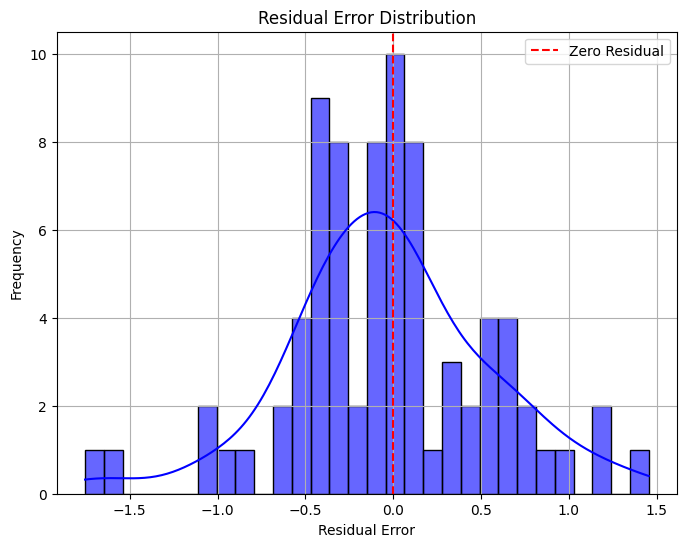

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Calculate residuals
residuals = true_prices - pred_prices

# Step 2: Plot residual distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='blue', alpha=0.6)
plt.axvline(x=0, color='red', linestyle='--', label='Zero Residual')
plt.title("Residual Error Distribution")
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

# Save the plot as error_distribution.png
plt.savefig('error_distribution.png')
plt.show()


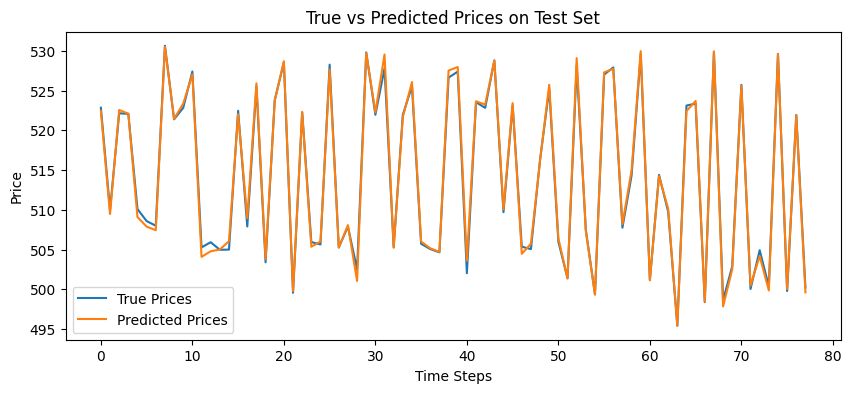

In [ ]:
mean_val = test_labels[:,2]  # mean
std_val = test_labels[:,3]   # std


true_prices = (test_labels[:,1] * std_val) + mean_val
pred_prices = (predictions[:,0] * std_val) + mean_val

plt.figure(figsize=(10,4))
plt.plot(true_prices, label='True Prices')
plt.plot(pred_prices, label='Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.title('True vs Predicted Prices on Test Set')
plt.legend()
plt.savefig('true_vs_pred.png')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(true_prices, pred_prices)
mae = mean_absolute_error(true_prices, pred_prices)
rmse = mse**0.5

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MSE: 0.4007943636395985
MAE: 0.5128643190059242
RMSE: 0.6330832201532421


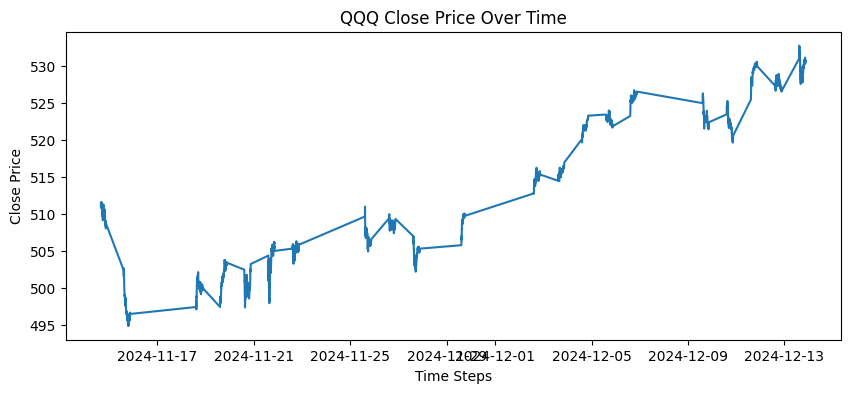

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df['QQQ_close'] * stats['QQQ_close_std'].values[0] + stats['QQQ_close_mean'].values[0])
plt.title('QQQ Close Price Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.savefig('data_overview.png')
plt.show()


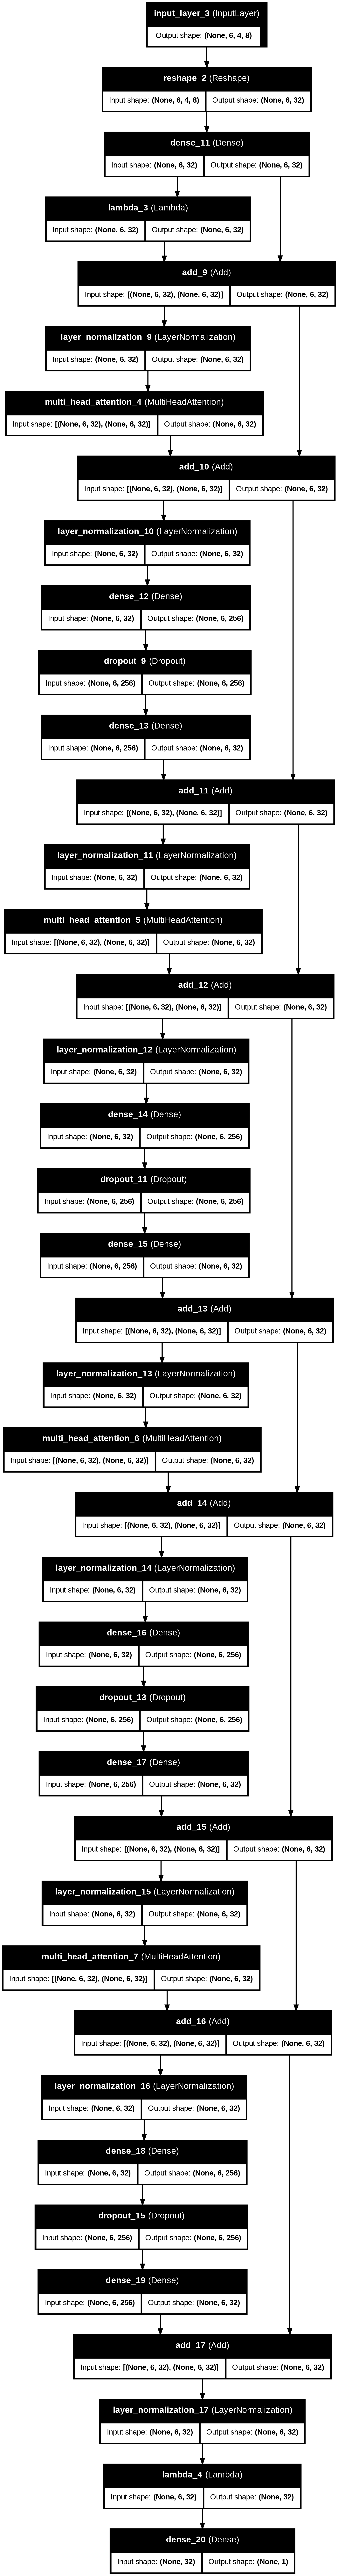

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)
